In [1]:
import cv2
import mediapipe as mp
import time
from scipy import spatial
from IPython.core.display import ProgressBar
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [4]:
VIDEO_PATH = 'videos/1.mp4'
HOLDS_PATH = 'images/combine_images.jpg'
width = 576
height = 1080

In [5]:
def array(vid_path):
    cap = cv2.VideoCapture(vid_path)
    vid_arr = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        vid_arr.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    cap.release()
    return np.array(vid_arr)

cropped = array(VIDEO_PATH)
cropped.shape

(531, 1280, 720, 3)

In [6]:
def crop(vid_arr, new_width, new_height):
    cropped_video = []
    for frame in vid_arr:
        im = Image.fromarray(frame)

        width, height = im.size
        left = (width - new_width) // 2
        top = (height - new_height) // 2
        right = left + new_width
        bottom = top + new_height

        cropped_video.append(np.array(im.crop((left, top, right, bottom))))

    return np.array(cropped_video)

In [7]:
def pose(vid_arr):
    pose = mp.solutions.pose.Pose()
    dict_coordinates = {
        'left_hand': [], 'right_hand': [],
        'left_hip': [], 'right_hip': [],
        'left_leg': [], 'right_leg': []
    }
    all_landmarks = []
    all_results = []
    frames = []

    for i, img in enumerate(vid_arr):
        results = pose.process(img)

        if results.pose_landmarks is not None:
            frames.append(i)
            h, w, _ = img.shape
            lm_list = [
                (int(lm.x * w), int(lm.y * h))
                for lm in results.pose_landmarks.landmark
            ]

            flat_lm_list = [coord for pair in lm_list for coord in pair]
            all_landmarks.append(flat_lm_list)
            all_results.append(results)

            dict_coordinates['left_hand'].append(lm_list[19])
            dict_coordinates['right_hand'].append(lm_list[20])
            dict_coordinates['left_hip'].append(lm_list[23])
            dict_coordinates['right_hip'].append(lm_list[24])
            dict_coordinates['left_leg'].append(lm_list[31])
            dict_coordinates['right_leg'].append(lm_list[32])

    return frames, all_results, all_landmarks, dict_coordinates

frames, results_arr, landmarks_arr, joint_positions = pose(cropped)
cropped = cropped.take(frames, axis=0)

I0000 00:00:1734748390.590665 5207365 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 76.3), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1734748390.751201 5207781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734748390.767498 5207781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734748390.794093 5207784 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/liuzhijia/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  

In [8]:
def significant(landmarks):
    from scipy.spatial.distance import cosine
    significant = []
    prev = None
    for i, current in enumerate(landmarks):
        if i == 0 or (1 - cosine(prev, current)) < 0.99999:
            significant.append(True)
        else:
            significant.append(False)
        prev = current
    return significant

significances = significant(landmarks_arr)

In [9]:
import predict_holds
hold_img = cv2.cvtColor(cv2.imread(HOLDS_PATH), cv2.COLOR_BGR2RGB)
status, response = predict_holds.predict_holds(hold_img)

In [10]:
def hold(dic):
    holds = [
        [
            (int(elem['x'] - elem['width'] / 2), int(elem['y'] - elem['height'] / 2)),
            (int(elem['x'] + elem['width'] / 2), int(elem['y'] + elem['height'] / 2))
        ]
        for elem in dic['predictions']
    ]
    return holds

climb_holds = hold(response)

In [11]:
def usedholds(holds, dict_coordinates):
    joint_list = list(zip(
        dict_coordinates['left_hand'],
        dict_coordinates['right_hand'],
        dict_coordinates['left_leg'],
        dict_coordinates['right_leg']
    ))

    holds_used = []
    for i in range(len(joint_list)):
        used_arr = []
        for hold in holds:
            jx_min, jy_min = hold[0]
            jx_max, jy_max = hold[1]

            current_usage = any(
                jx_min <= joint[0] <= jx_max and jy_min <= joint[1] <= jy_max
                for joint in joint_list[i]
            )

            if current_usage and i + 1 < len(joint_list):
                next_usage = any(
                    jx_min <= joint[0] <= jx_max and jy_min <= joint[1] <= jy_max
                    for joint in joint_list[i + 1]
                )
                used_arr.append(next_usage)
            else:
                used_arr.append(current_usage)
        holds_used.append(used_arr)

    return holds_used

climb_holds_used = usedholds(climb_holds, joint_positions)

In [12]:
def videogenerator(vid_arr, holds, holds_used, pose_results, dict_coordinates, frame_significances):
    joint_list = list(zip(
        dict_coordinates['left_hand'],
        dict_coordinates['right_hand'],
        dict_coordinates['left_hip'],
        dict_coordinates['right_hip'],
        dict_coordinates['left_leg'],
        dict_coordinates['right_leg']
    ))

    plotted_frames = []

    for t, frame in enumerate(vid_arr):
        if not frame_significances[t]:
            continue

        used = holds_used[t]
        results = pose_results[t]

        for h, is_used in enumerate(used):
            if is_used:
                frame = cv2.rectangle(frame, holds[h][0], holds[h][1], (0, 255, 120), 5)

        mp.solutions.drawing_utils.draw_landmarks(
            frame, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS
        )

        for cx, cy in joint_list[t]:
            frame = cv2.circle(frame, (cx, cy), 5, (255, 0, 150), cv2.FILLED)

        plotted_frames.append(frame)

    return np.array(plotted_frames)

video = videogenerator(cropped, climb_holds, climb_holds_used, results_arr, joint_positions, significances)
video.shape

(480, 1280, 720, 3)

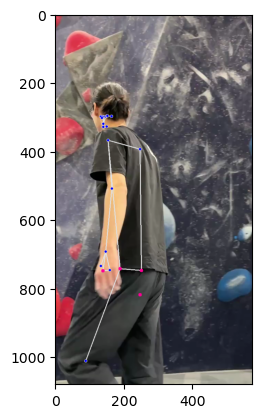

In [13]:
test = crop(video, width, height)
plt.imshow(test[0])

In [14]:
frameSize = (width, height)
fourcc= cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('test.avi', fourcc, 5, (width, height), isColor=True)

for i in range(test.shape[0]):
    img = test[i]
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()